## Load dataset

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install -q kaggle

ERROR: Could not install packages due to an OSError: [WinError 2] A rendszer nem találja a megadott fájlt: 'C:\\Python311\\Scripts\\kaggle.exe' -> 'C:\\Python311\\Scripts\\kaggle.exe.deleteme'


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# download api token from: https://www.kaggle.com/settings -> and upload here:
# from google.colab import files

# files.upload()

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nguyentuannguyen/optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.
'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
train_dataset = pd.read_csv('/content/optiver-trading-at-the-close/train.csv')
train_dataset.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/optiver-trading-at-the-close/train.csv'

## Local

In [2]:
train_dataset = pd.read_csv('content/optiver-trading-at-the-close/train.csv')
train_dataset.shape

(5237980, 17)

## Feature selection and engineering

In [3]:
# List of columns to convert to float32
columns_to_convert = ['reference_price', 'matched_size', 'far_price', 'near_price',
                      'bid_price', 'bid_size', 'ask_price', 'ask_size',
                      'wap', 'target', 'imbalance_size']

# Convert the columns to float32
train_dataset[columns_to_convert] = train_dataset[columns_to_convert].astype('float32')
train_dataset.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float32
imbalance_buy_sell_flag      int64
reference_price            float32
matched_size               float32
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float32
ask_price                  float32
ask_size                   float32
wap                        float32
target                     float32
time_id                      int64
row_id                      object
dtype: object

In [4]:
from sklearn.preprocessing import QuantileTransformer
# Applying Quantile Transformation to follow a normal distribution

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
train_dataset['Quantile_imbalance_size'] = quantile_transformer.fit_transform(train_dataset['imbalance_size'].values.reshape(-1, 1)).flatten()
train_dataset['Quantile_far_price'] = quantile_transformer.fit_transform(train_dataset['far_price'].values.reshape(-1, 1)).flatten()

# bid_size
train_dataset['Quantile_bid_size'] = quantile_transformer.fit_transform(train_dataset['bid_size'].values.reshape(-1, 1)).flatten()

# ask_size
train_dataset['Quantile_ask_size'] = quantile_transformer.fit_transform(train_dataset['ask_size'].values.reshape(-1, 1)).flatten()

In [5]:
# original features
features = ['imbalance_size', 'far_price', 'bid_size', 'ask_size']

# drop features
train_dataset = train_dataset.drop(features, axis=1)

In [6]:
def inspect_columns(df):
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
#         'null_num': df.isnull().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
#         '1st_row': df.iloc[0],
#         'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(train_dataset)

,unique,cardinality,with_null,null_pct,dtype
stock_id,False,200,False,0.00,int64
date_id,False,481,False,0.00,int64
seconds_in_bucket,False,55,False,0.00,int64
imbalance_buy_sell_flag,False,3,False,0.00,int64
reference_price,False,28741,True,0.00,float32
matched_size,False,2875627,True,0.00,float32
near_price,False,84625,True,54.55,float32
bid_price,False,28313,True,0.00,float32
ask_price,False,28266,True,0.00,float32
wap,False,31506,True,0.00,float32


In [7]:
train_dataset['volume'] = train_dataset['Quantile_ask_size'] + train_dataset['Quantile_bid_size']
train_dataset['volume_norm'] = (train_dataset['volume'] - train_dataset['volume'].mean()) / train_dataset['volume'].std()

In [8]:
df_train = train_dataset.copy()

def drop_missing_values(df):
    # drop the missing values of wap
    df = df.dropna(subset=['wap'])
    return df
# drop the missing values of wap
df_train = drop_missing_values(df_train)
df_train.shape

(5237760, 19)

##### keep only the features selected in "trading_at_the_close_visualisation"
 ['stock_id' 'date_id' 'seconds_in_bucket' 'imbalance_size'
 'reference_price' 'matched_size' 'far_price' 'near_price' 'bid_price'
 'bid_size' 'ask_price' 'ask_size' 'wap' 'row_id' 'date_id_week'
 'date_id_seconds' 'total_volume' 'near_far_ratio' 'near_far_imbalance'
 'ask_mat_ratio' 'bid_mat_ratio' 'ask_ref_ratio'
 'imbalance_continuous_ratio' 'ask_wap_diff' 'all_prices_skew'
 'all_sizes_skew' 'all_prices_kurt' 'all_sizes_kurt'
 'imbalance_buy_sell_flag_cumsum' 'imbalance_buy_sell_flag_0'
 'imbalance_buy_sell_flag_1']


In [9]:
%%time

def calc_feature_single_stock(df):
    # Feature of each stock at different time point
    # date_id
    df["date_id_week"] = df["date_id"] % 5  # Day of the week
    df["date_id_seconds"] = df["seconds_in_bucket"] % 60  # Seconds
   
    
    # ask bid 
    df['spread'] = df['ask_price'] - df['bid_price']
   
    df['mid_price'] = (df['bid_price'] + df['ask_price'])/2
    # product of imbalance size and bid-ask spread
    df["price_pressure"] = df["Quantile_imbalance_size"] * (df["spread"])
    
    # near_price far_price
    df['near_far_ratio'] = df['near_price'] / df['Quantile_far_price']
    df['near_far_imbalance'] = (df['Quantile_far_price'] - df['near_price']) / (df['Quantile_far_price'] + df['near_price'])
   
    
    #The ratio between ask/bid and matched sizes provides insights into market liquidity and order flow:
    # A high ask-to-matched ratio suggests that there are more sellers than buyers at a given price level, 
    # potentially indicating resistance to upward price movement.
    # Conversely, a low ratio implies stronger buying interest and potential support for price increases.
    
    df['ask_mat_ratio'] = df['Quantile_ask_size']/df['matched_size']
    df['bid_mat_ratio'] = df['Quantile_bid_size']/df['matched_size']
    
    # The ratio between the ask/bid price and the reference price provides insights into market sentiment:
    # - Above 1: If the ask/bid price is higher than the reference price, it suggests bullish sentiment. Sellers are demanding a premium.
    # - Below 1: If the ask/bid price is lower than the reference price, it indicates bearish sentiment. Buyers are getting a discount.
    df['ask_ref_ratio'] = df['ask_price']/df['reference_price']
    # imbalance_size matched_size
    df['auction_volume'] = df['Quantile_imbalance_size'] + df['matched_size']
    # relative imbalance between matched and total size
    df["imbalance_ratio"] = (df["Quantile_imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["Quantile_imbalance_size"])
    # cross term 
    df["imbalance_continuous_ratio"] = df['Quantile_imbalance_size'] / df["volume"]
    # the overall level of buying and selling in financial markets
    df['market_activity'] = df['Quantile_bid_size'] * df['bid_price'] + df['Quantile_ask_size'] * df['ask_price']
    # The difference between the ask/bid price and the WAP can indicate market efficiency.
    df['ask_wap_diff'] = df['ask_price'] - df['wap']
    # Accumulative features
    df['imbalance_buy_sell_flag_cumsum'] =  df.groupby(['stock_id','date_id'])['imbalance_buy_sell_flag'].cumsum()
    
    # statistical features at different time point
    prices = ["reference_price", "Quantile_far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "Quantile_bid_size", "Quantile_ask_size", "Quantile_imbalance_size"]
    for func in ["mean", "std", "skew", "kurt"]:
            df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
            df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
            

    return df

df_train = calc_feature_single_stock(df_train)
df_train.tail()


CPU times: total: 6.09 s
Wall time: 8.01 s


,stock_id,date_id,seconds_in_bucket,imbalance_buy_sell_flag,reference_price,matched_size,near_price,bid_price,ask_price,wap,...,ask_wap_diff,imbalance_buy_sell_flag_cumsum,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt
5237975,195,480,540,-1,1.000317,28280362.0,0.999734,1.000317,1.000434,1.000328,...,0.000106,-54,0.830386,7070091.00,0.416020,14140180.0,-2.449488,2.0,5.999992,4.0
5237976,196,480,540,-1,1.000643,9187699.0,1.000386,1.000643,1.000900,1.000819,...,0.000081,-55,0.847850,2296925.50,0.374351,4593849.0,-2.449489,2.0,5.999995,4.0
5237977,197,480,540,0,0.995789,12725436.0,0.995789,0.995789,0.995883,0.995797,...,0.000086,-54,0.705909,3181358.25,0.710108,6362718.5,-2.449490,2.0,6.000000,4.0
5237978,198,480,540,1,0.999210,94773272.0,0.999210,0.998970,0.999210,0.999008,...,0.000202,28,0.809469,23693318.00,0.464552,47386636.0,-2.449490,2.0,5.999999,4.0
5237979,199,480,540,-1,1.002129,24073678.0,1.001494,1.002129,1.002447,1.002274,...,0.000173,-35,0.882249,6018420.50,0.293562,12036838.0,-2.449483,2.0,5.999975,4.0


In [10]:
# def calculate_vwap(df):
#     df['vwap_reference_price'] = (df['wap'] * df['reference_price']).cumsum() / df['volume'].cumsum()
#     return df
# df_train = calculate_vwap(df_train)
# df_train.head()

In [11]:
df_train['rolling_std_reference_price'] = df_train.groupby('stock_id')['reference_price'].transform(lambda x: x.rolling(window=54).std())

In [12]:
# make dummy from imbalance_buy_sell_flag and get dummy columns
dummy_cols_list = ['imbalance_buy_sell_flag']
dummy_names = []

for col in dummy_cols_list:
    dummy_df = pd.get_dummies(df_train.loc[:, col], prefix=col, drop_first=True)
    dummy_names += dummy_df.columns.tolist()
    # drop original column
    df_train = df_train.drop(col, axis=1)
    df_train = pd.concat([df_train, dummy_df], axis=1)

In [13]:

# drop these columns
df_train = df_train.drop(['all_sizes_std','all_prices_std','all_sizes_mean','market_activity','mid_price'], axis=1)
# drop: near_far_mid, auction_volume,all_prices_mean
df_train = df_train.drop([ 'auction_volume','all_prices_mean'], axis=1)


# drop: time_id
df_train = df_train.drop(['time_id'], axis=1)

The result of feature selection (trading_at_the_close_visualisation_1.ipynb)

In [14]:
# selected_features = ['stock_id','target','imbalance_buy_sell_flag_0','imbalance_buy_sell_flag_1', 'rolling_std_reference_price','date_id','seconds_in_bucket', 'ask_ref_ratio', 'Quantile_bid_size', 'Quantile_ask_size',  'ask_wap_diff', 'spread']

# # keep only the selected features
# df_train = df_train[selected_features]

# Load from preprocessed file

In [15]:
# # load preprocess data
# df_train = pd.read_csv('data/optiver-trading-at-the-close/train_preprocess_short.csv')

# selected_features = ['stock_id','target','imbalance_buy_sell_flag_0','imbalance_buy_sell_flag_1', 'rolling_std_matched_size','date_id','seconds_in_bucket', 'ask_ref_ratio', 'Quantile_bid_size', 'Quantile_ask_size',  'ask_wap_diff', 'spread']

# # keep only the selected features
# df_train = df_train[selected_features]

# LSTM

In [16]:
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import numpy as np
import tensorflow as tf
import random as python_random
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
from xgboost import XGBRegressor, plot_importance

In [17]:
SEED = 42
N_LAGS = 55
BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPOCHS = 10
PATIENCE = 25
DROPOUT = 0.5
LEARNING_RATE = 1e-4
SPLIT_DAY_VALID = 360
SPLIT_DAY_TEST = 420
N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55
RUN_TRAINING = True
RUN_FOR_SUBMISSION = True

DATA FORMATTER

In [18]:

# def windowed_dataset(dataset, shuffle=True):
#     dataset = tf.data.Dataset.from_tensor_slices(dataset)
#     dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
#     dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#     if shuffle:
#       dataset = dataset.shuffle(BUFFER_SIZE)
#     dataset = dataset.batch(BATCH_SIZE).prefetch(1)
#     return dataset


# def build_features(df):

#     all_stock_ids = range(N_STOCKS)
#     all_date_ids = df["date_id"].unique()
#     all_seconds = [i * 10 for i in range(N_SECONDS)]

#     multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
#                                              names=['stock_id', 'date_id', 'seconds_in_bucket'])
#     df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
#     df_full = df_full.fillna(0)
#     df_full = df_full.reset_index()

#     df_pivoted = df_full.pivot_table(
#                 values='target',
#                 index=['date_id', 'seconds_in_bucket'],
#                 columns='stock_id')

#     df_pivoted = df_pivoted.reset_index(drop=True)
#     df_pivoted.columns.name = None

#     return df_pivoted

def split_dataframe(df, n_steps):
    X, y = [], []
    for i in range(len(df) - n_steps):
        seq_x = df.iloc[i:i+n_steps, :-1]
        seq_y = df.iloc[i+n_steps, -1]
        X.append(seq_x)
        y.append(seq_y)
    return pd.concat(X), pd.Series(y)

In [19]:
def reindex_data(df):
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)
    df_full = df_full.reset_index()
    
    return df_full

In [20]:
split_dataframe(df_train[:20], 10)

(    stock_id  date_id  seconds_in_bucket  reference_price  matched_size  \
 0          0        0                  0         0.999812  1.338028e+07   
 1          1        0                  0         0.999896  1.642214e+06   
 2          2        0                  0         0.999561  1.819368e+06   
 3          3        0                  0         1.000171  1.838975e+07   
 4          4        0                  0         0.999532  1.786061e+07   
 ..       ...      ...                ...              ...           ...   
 14        14        0                  0         1.000495  3.902048e+07   
 15        15        0                  0         0.999403  1.765836e+06   
 16        16        0                  0         0.999258  3.438806e+06   
 17        17        0                  0         1.000966  2.728888e+07   
 18        18        0                  0         1.000029  1.263452e+06   
 
     near_price  bid_price  ask_price  wap     target  ... imbalance_ratio  \
 0      

In [21]:
target = df_train['target'] 
df_train = df_train.drop(['target'], axis=1)
df_train = pd.concat([df_train, target], axis=1)

In [22]:
# x_train, y_train = split_dataframe(df_train, N_LAGS)
# x_train.shape, y_train.shape

In [23]:
def standardize(df):
    #Standardize by stock ID (each stock is fit to have SD=1 and mean 0)
    def standardize_stock(group):
        columns_to_scale = group.columns.difference(['stock_id', 'date_id', 'seconds_in_bucket'])
        scaler = StandardScaler()
        group[columns_to_scale] = scaler.fit_transform(group[columns_to_scale])
        return group

    # Reset index if 'stock_id' is part of the index
    if 'stock_id' in df.index.names:
        df = df.reset_index()

    # Apply standardization to each stock group
    df_scaled = df.groupby('stock_id').apply(standardize_stock)

    # Reset index to flatten the DataFrame after groupby
    df_scaled = df_scaled.reset_index(drop=True)

    # Sort by 'stock_id', 'date_id', 'seconds_in_bucket'


    return df_scaled


def rolling_average(df):
    # Define a function to apply the rolling average within each group
    def apply_rolling(group):
        # Calculate rolling average without looking ahead
        rolling_avg = group['reference_price'].rolling(window=10, min_periods=1).mean()
        # Fill NaN values (for the first 9 elements in each group) with 1
        rolling_avg.iloc[:9] = 0
        return rolling_avg

    # Group by 'stock_id' and 'date_id', then apply the rolling function
    df['rolling_avg'] = df.groupby(['stock_id', 'date_id']).apply(apply_rolling).reset_index(level=[0,1], drop=True)

    return df

def data_preprocessing(df):
    df2 = standardize(df)
    df3 = rolling_average(df2)
    return df3

In [24]:
x = df_train.copy()
x = data_preprocessing(x)
x.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_32880\3178404642.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_scaled = df.groupby('stock_id').apply(standardize_stock)
C:\Users\PC\AppData\Local\Temp\ipykernel_32880\3178404642.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['rolling_avg'] = df.groupby(['stock_id', 'date_id']).apply(apply_rolling).reset_index(level=[0,1], drop=True)


,stock_id,date_id,seconds_in_bucket,reference_price,matched_size,near_price,bid_price,ask_price,wap,row_id,...,imbalance_buy_sell_flag_cumsum,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,rolling_std_reference_price,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1,target,rolling_avg
0,0,0,0,-0.013514,-0.587920,NaN,0.045707,0.042618,0.094031,-1.325292,...,0.202334,0.495221,0.0,-0.828737,0.0,NaN,-0.471884,1.420895,-0.457324,0.0
1,0,0,10,0.113968,-0.498562,NaN,0.045707,0.042618,0.029650,-1.325226,...,0.243711,0.186134,0.0,-0.828737,0.0,NaN,-0.471884,1.420895,0.107501,0.0
2,0,0,20,0.050227,-0.498562,NaN,0.045707,-0.021118,-0.000160,-1.325160,...,0.285088,0.316323,0.0,-0.828737,0.0,NaN,-0.471884,1.420895,0.740160,0.0
3,0,0,30,0.177744,-0.498562,NaN,0.173491,0.106389,0.144698,-1.325094,...,0.326464,-0.146836,0.0,-0.828737,0.0,NaN,-0.471884,1.420895,0.943367,0.0
4,0,0,40,0.369570,-0.494687,NaN,0.301915,0.298201,0.282982,-1.325028,...,0.367841,0.215635,0.0,-0.828737,0.0,NaN,-0.471884,1.420895,0.566686,0.0


In [25]:
x['imbalance_buy_sell_flag_0']=df_train['imbalance_buy_sell_flag_0']
x['imbalance_buy_sell_flag_1']=df_train['imbalance_buy_sell_flag_1']
x['target'] = df_train['target']
x

,stock_id,date_id,seconds_in_bucket,reference_price,matched_size,near_price,bid_price,ask_price,wap,row_id,...,imbalance_buy_sell_flag_cumsum,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,rolling_std_reference_price,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1,target,rolling_avg
0,0,0,0,-0.013514,-0.587920,NaN,0.045707,0.042618,0.094031,-1.325292,...,0.202334,0.495221,0.0,-0.828737,0.0,NaN,False,True,-3.029704,0.000000
1,0,0,10,0.113968,-0.498562,NaN,0.045707,0.042618,0.029650,-1.325226,...,0.243711,0.186134,0.0,-0.828737,0.0,NaN,False,False,-5.519986,0.000000
2,0,0,20,0.050227,-0.498562,NaN,0.045707,-0.021118,-0.000160,-1.325160,...,0.285088,0.316323,0.0,-0.828737,0.0,NaN,False,False,-8.389950,0.000000
3,0,0,30,0.177744,-0.498562,NaN,0.173491,0.106389,0.144698,-1.325094,...,0.326464,-0.146836,0.0,-0.828737,0.0,NaN,False,False,-4.010201,0.000000
4,0,0,40,0.369570,-0.494687,NaN,0.301915,0.298201,0.282982,-1.325028,...,0.367841,0.215635,0.0,-0.828737,0.0,NaN,False,False,-7.349849,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237755,199,480,500,1.221904,-0.008921,0.142269,1.316295,1.296892,1.262749,1.698456,...,-1.285681,-1.000578,0.0,0.955142,0.0,-0.937949,False,False,-2.310276,0.815330
5237756,199,480,510,1.221904,-0.008855,0.142269,1.316295,1.296892,1.326822,1.698526,...,-1.327371,-1.000577,0.0,0.955141,0.0,-0.983926,False,False,1.469851,0.873435
5237757,199,480,520,0.786318,-0.008710,0.142269,0.876050,0.856136,0.869522,1.698596,...,-1.369060,-1.000588,0.0,0.955159,0.0,-1.073713,False,False,-5.289912,0.873435
5237758,199,480,530,0.786318,-0.008710,0.142269,0.876050,0.856136,0.874577,1.698665,...,-1.410750,-1.000588,0.0,0.955159,0.0,-1.177747,False,False,0.070333,0.873435


In [26]:
x.isna().sum()

stock_id                                0
date_id                                 0
seconds_in_bucket                       0
reference_price                         0
matched_size                            0
near_price                        2856960
bid_price                               0
ask_price                               0
wap                                     0
row_id                                  0
Quantile_imbalance_size                 0
Quantile_far_price                2894122
Quantile_bid_size                       0
Quantile_ask_size                       0
volume                                  0
volume_norm                             0
date_id_week                            0
date_id_seconds                         0
spread                                  0
price_pressure                          0
near_far_ratio                    2894122
near_far_imbalance                2894122
ask_mat_ratio                           0
bid_mat_ratio                     

In [27]:
def data_preprocessing_lstm(x,test_train):
    
    for i in x.columns:
        if x[i].isnull().sum()>0:
            x[i].fillna(x[i].mean(),inplace=True)

    seconds = x['seconds_in_bucket']
    x = x.drop(['seconds_in_bucket'],axis=1)      
    # Extract and encode catagorical columns
    categorical_cols = ['stock_id', 'imbalance_buy_sell_flag_0', 'imbalance_buy_sell_flag_1']
    x_cat = x[categorical_cols]

    for col in categorical_cols:
        x_cat[col] = x_cat[col].astype('category').cat.codes

    # Scale numeric columns
    target = x['target']
    x = x.drop(['target'],axis=1)  
    x_num = x.drop(categorical_cols, axis=1)
    scaler = StandardScaler()
    x_num = pd.DataFrame(scaler.fit_transform(x_num),columns=x_num.columns)
    x_num['date_id'] = x['date_id']

    # Conct back into single DF
    x = pd.concat([x_cat, x_num,seconds,target], axis=1)
    x_test = x[x['date_id']>=test_train]
    # x_test.drop(['date_id'],axis=1,inplace=True)
    x_test = x_test.dropna()

    x_train = x[x['date_id']<test_train]
    # x_train.drop(['date_id'],axis=1,inplace=True)
    x_train = x_train.dropna()
    return x_test, x_train

In [28]:
x_test, x_train = data_preprocessing_lstm(x,380)
x_temp = x_test.copy()
x_test = x_temp[x_temp['date_id']>=450]
x_val = x_temp[x_temp['date_id']<450]

y_train = x_train[['stock_id','date_id','target']]
x_train = x_train.drop(['target'],axis=1)

y_test = x_test[['stock_id','date_id','target']]
x_test = x_test.drop(['target'],axis=1)

y_val = x_val[['stock_id','date_id','target']]
x_val = x_val.drop(['target'],axis=1)

C:\Users\PC\AppData\Local\Temp\ipykernel_32880\2301214620.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x[i].fillna(x[i].mean(),inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_32880\2301214620.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cat[col] = x_cat[col].astyp

In [29]:
agg_x_train_df = x_train.groupby(['stock_id','date_id']).agg({
    'reference_price': list,
    'matched_size': list,
    'near_price': list,
    'bid_price': list,
    'ask_price': list,
    'wap': list,
    'Quantile_imbalance_size': list,
    'Quantile_far_price': list,
    'Quantile_bid_size': list,
    'Quantile_ask_size': list,
    'volume': list,
    'volume_norm': list,
    #'date_id_week': list,
    #'date_id_seconds': list,
    'spread': list,
    'price_pressure': list,
    'near_far_ratio': list,
    'near_far_imbalance': list,
    'ask_mat_ratio': list,
    'bid_mat_ratio': list,
    'ask_ref_ratio': list,
    'imbalance_ratio': list,
    'imbalance_continuous_ratio': list,
    'ask_wap_diff': list,
    'imbalance_buy_sell_flag_cumsum': list,
    'all_prices_skew': list,
    'all_sizes_skew': list,
    'all_prices_kurt': list,
    'all_sizes_kurt': list,
    'rolling_std_reference_price': list,
    'rolling_avg': list,
    'imbalance_buy_sell_flag_0': list,
    'imbalance_buy_sell_flag_1': list,
}).reset_index()

agg_x_train_df.columns = [
    'stock_id',
    'date_id',
    'reference_price',
    'matched_size',
    'near_price',
    'bid_price',
    'ask_price',
    'wap',
    'Quantile_imbalance_size',
    'Quantile_far_price',
    'Quantile_bid_size',
    'Quantile_ask_size',
    'volume',
    'volume_norm',
    #'date_id_week',
    #'date_id_seconds',
    'spread',
    'price_pressure',
    'near_far_ratio',
    'near_far_imbalance',
    'ask_mat_ratio',
    'bid_mat_ratio',
    'ask_ref_ratio',
    'imbalance_ratio',
    'imbalance_continuous_ratio',
    'ask_wap_diff',
    'imbalance_buy_sell_flag_cumsum',
    'all_prices_skew',
    'all_sizes_skew',
    'all_prices_kurt',
    'all_sizes_kurt',
    'rolling_std_reference_price',
    'rolling_avg',
    'imbalance_buy_sell_flag_0',
    'imbalance_buy_sell_flag_1',
]

agg_x_test_df = x_test.groupby(['stock_id','date_id']).agg({
    'reference_price': list,
    'matched_size': list,
    'near_price': list,
    'bid_price': list,
    'ask_price': list,
    'wap': list,
    'Quantile_imbalance_size': list,
    'Quantile_far_price': list,
    'Quantile_bid_size': list,
    'Quantile_ask_size': list,
    'volume': list,
    'volume_norm': list,
    #'date_id_week': list,
    #'date_id_seconds': list,
    'spread': list,
    'price_pressure': list,
    'near_far_ratio': list,
    'near_far_imbalance': list,
    'ask_mat_ratio': list,
    'bid_mat_ratio': list,
    'ask_ref_ratio': list,
    'imbalance_ratio': list,
    'imbalance_continuous_ratio': list,
    'ask_wap_diff': list,
    'imbalance_buy_sell_flag_cumsum': list,
    'all_prices_skew': list,
    'all_sizes_skew': list,
    'all_prices_kurt': list,
    'all_sizes_kurt': list,
    'rolling_std_reference_price': list,
    'rolling_avg': list,
    'imbalance_buy_sell_flag_0': list,
    'imbalance_buy_sell_flag_1': list,
}).reset_index()

agg_x_test_df.columns = [
    'stock_id',
    'date_id',
    'reference_price',
    'matched_size',
    'near_price',
    'bid_price',
    'ask_price',
    'wap',
    'Quantile_imbalance_size',
    'Quantile_far_price',
    'Quantile_bid_size',
    'Quantile_ask_size',
    'volume',
    'volume_norm',
    #'date_id_week',
    #'date_id_seconds',
    'spread',
    'price_pressure',
    'near_far_ratio',
    'near_far_imbalance',
    'ask_mat_ratio',
    'bid_mat_ratio',
    'ask_ref_ratio',
    'imbalance_ratio',
    'imbalance_continuous_ratio',
    'ask_wap_diff',
    'imbalance_buy_sell_flag_cumsum',
    'all_prices_skew',
    'all_sizes_skew',
    'all_prices_kurt',
    'all_sizes_kurt',
    'rolling_std_reference_price',
    'rolling_avg',
    'imbalance_buy_sell_flag_0',
    'imbalance_buy_sell_flag_1',
]

agg_x_val_df = x_val.groupby(['stock_id','date_id']).agg({
    'reference_price': list,
    'matched_size': list,
    'near_price': list,
    'bid_price': list,
    'ask_price': list,
    'wap': list,
    'Quantile_imbalance_size': list,
    'Quantile_far_price': list,
    'Quantile_bid_size': list,
    'Quantile_ask_size': list,
    'volume': list,
    'volume_norm': list,
    #'date_id_week': list,
    #'date_id_seconds': list,
    'spread': list,
    'price_pressure': list,
    'near_far_ratio': list,
    'near_far_imbalance': list,
    'ask_mat_ratio': list,
    'bid_mat_ratio': list,
    'ask_ref_ratio': list,
    'imbalance_ratio': list,
    'imbalance_continuous_ratio': list,
    'ask_wap_diff': list,
    'imbalance_buy_sell_flag_cumsum': list,
    'all_prices_skew': list,
    'all_sizes_skew': list,
    'all_prices_kurt': list,
    'all_sizes_kurt': list,
    'rolling_std_reference_price': list,
    'rolling_avg': list,
    'imbalance_buy_sell_flag_0': list,
    'imbalance_buy_sell_flag_1': list,
}).reset_index()

agg_x_val_df.columns = [
    'stock_id',
    'date_id',
    'reference_price',
    'matched_size',
    'near_price',
    'bid_price',
    'ask_price',
    'wap',
    'Quantile_imbalance_size',
    'Quantile_far_price',
    'Quantile_bid_size',
    'Quantile_ask_size',
    'volume',
    'volume_norm',
    #'date_id_week',
    #'date_id_seconds',
    'spread',
    'price_pressure',
    'near_far_ratio',
    'near_far_imbalance',
    'ask_mat_ratio',
    'bid_mat_ratio',
    'ask_ref_ratio',
    'imbalance_ratio',
    'imbalance_continuous_ratio',
    'ask_wap_diff',
    'imbalance_buy_sell_flag_cumsum',
    'all_prices_skew',
    'all_sizes_skew',
    'all_prices_kurt',
    'all_sizes_kurt',
    'rolling_std_reference_price',
    'rolling_avg',
    'imbalance_buy_sell_flag_0',
    'imbalance_buy_sell_flag_1',
]

In [30]:
agg_y_train_df = y_train.groupby(['stock_id','date_id']).agg({
    'target': list
}).reset_index()

agg_y_train_df.columns = [
    'stock_id',
    'date_id',
    'target'
]

agg_y_test_df = y_test.groupby(['stock_id','date_id']).agg({
    'target': list
}).reset_index()

agg_y_test_df.columns = [
    'stock_id',
    'date_id',
    'target'
]

agg_y_val_df = y_val.groupby(['stock_id','date_id']).agg({
    'target': list
}).reset_index()

agg_y_val_df.columns = [
    'stock_id',
    'date_id',
    'target'
]

In [31]:
cols = [    
    'reference_price',
    'matched_size',
    'near_price',
    'bid_price',
    'ask_price',
    'wap',
    'Quantile_imbalance_size',
    'Quantile_far_price',
    'Quantile_bid_size',
    'Quantile_ask_size',
    'volume',
    'volume_norm',
    #'date_id_week',
    #'date_id_seconds',
    'spread',
    'price_pressure',
    'near_far_ratio',
    'near_far_imbalance',
    'ask_mat_ratio',
    'bid_mat_ratio',
    'ask_ref_ratio',
    'imbalance_ratio',
    'imbalance_continuous_ratio',
    'ask_wap_diff',
    'imbalance_buy_sell_flag_cumsum',
    'all_prices_skew',
    'all_sizes_skew',
    'all_prices_kurt',
    'all_sizes_kurt',
    'rolling_std_reference_price',
    'rolling_avg',
    'imbalance_buy_sell_flag_0',
    'imbalance_buy_sell_flag_1',
    ]

import numpy as np

# Convert columns to float or categorical format in agg_x_train_df
agg_x_train_df = agg_x_train_df.applymap(lambda x: np.asarray(x).astype('float32') if isinstance(x, list) else x)
agg_x_train_df['stock_id'] = agg_x_train_df['stock_id'].astype('float32')
agg_x_train_df['date_id'] = agg_x_train_df['date_id'].astype('float32')

# Convert columns to 'float32' or categorical format in agg_x_val_df
agg_x_val_df = agg_x_val_df.applymap(lambda x: np.asarray(x).astype('float32') if isinstance(x, list) else x)
agg_x_val_df['stock_id'] = agg_x_val_df['stock_id'].astype('float32')
agg_x_val_df['date_id'] = agg_x_val_df['date_id'].astype('float32')

# Convert columns to 'float32' or categorical format in agg_x_test_df
agg_x_test_df = agg_x_test_df.applymap(lambda x: np.asarray(x).astype('float32') if isinstance(x, list) else x)
agg_x_test_df['stock_id'] = agg_x_test_df['stock_id'].astype('float32')
agg_x_test_df['date_id'] = agg_x_test_df['date_id'].astype('float32')


C:\Users\PC\AppData\Local\Temp\ipykernel_32880\2503442446.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  agg_x_train_df = agg_x_train_df.applymap(lambda x: np.asarray(x).astype('float32') if isinstance(x, list) else x)
C:\Users\PC\AppData\Local\Temp\ipykernel_32880\2503442446.py:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  agg_x_val_df = agg_x_val_df.applymap(lambda x: np.asarray(x).astype('float32') if isinstance(x, list) else x)
C:\Users\PC\AppData\Local\Temp\ipykernel_32880\2503442446.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  agg_x_test_df = agg_x_test_df.applymap(lambda x: np.asarray(x).astype('float32') if isinstance(x, list) else x)


In [41]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, RepeatVector, UpSampling1D, Concatenate,ConvLSTM1D, Attention,Embedding, GRU, SimpleRNN, LayerNormalization, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Bidirectional, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#Cathegorical data input-------------------------------------------------------------------------------------------------------
embedding_dim = 12
vocab_size_cat0 = len(x_train['stock_id'].unique())
vocab_size_cat1 = len(x_train['date_id'].unique())
out_size_0 = len(agg_x_train_df['imbalance_buy_sell_flag_0'][0])
out_size_1 = len(agg_x_train_df['imbalance_buy_sell_flag_1'][0])

input_cat0 = Input(shape=(1,), name='stock_id_input')
emb0 = Embedding(input_dim=201, output_dim=embedding_dim, input_length = 1, name = "stock_id_emb")(input_cat0)

input_cat1 = Input(shape=(1,), name='date_id_input')
emb1 = Embedding(input_dim=481, output_dim=embedding_dim, input_length = 1, name = "date_id_emb")(input_cat1)

concat = Concatenate()([emb0, emb1])


#Sequential data inputs-------------------------------------------------------------------------------------------------------
reference_price_input = Input(shape=(out_size_0, 1), name="reference_price_input")
small_lstm_1 = LSTM(16, activation="tanh", return_sequences=True)(reference_price_input)
lstm_1 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_1)

matched_size_input = Input(shape=(out_size_0, 1), name="matched_size_input")
small_lstm_2 = LSTM(16, activation="tanh", return_sequences=True)(matched_size_input)
lstm_2 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_2)

near_price_input = Input(shape=(out_size_0, 1), name="near_price_input")
small_lstm_3 = LSTM(16, activation="tanh", return_sequences=True)(near_price_input)
lstm_3 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_3)

bid_price_input = Input(shape=(out_size_0, 1), name="bid_price_input")
small_lstm_4 = LSTM(16, activation="tanh", return_sequences=True)(bid_price_input)
lstm_4 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_4)

ask_price_input = Input(shape=(out_size_0, 1), name="ask_price_input")
small_lstm_5 = LSTM(16, activation="tanh", return_sequences=True)(ask_price_input)
lstm_5 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_5)

wap_input = Input(shape=(out_size_0, 1), name="wap_input")
small_lstm_6 = LSTM(16, activation="tanh", return_sequences=True)(wap_input)
lstm_6 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_6)

Quantile_imbalance_size_input = Input(shape=(out_size_0, 1), name="Quantile_imbalance_size_input")
small_lstm_7 = LSTM(16, activation="tanh", return_sequences=True)(Quantile_imbalance_size_input)
lstm_7 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_7)

Quantile_far_price_input = Input(shape=(out_size_0, 1), name="Quantile_far_price_input")
small_lstm_8 = LSTM(16, activation="tanh", return_sequences=True)(Quantile_far_price_input)
lstm_8 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_8)

Quantile_bid_size_input = Input(shape=(out_size_0, 1), name="Quantile_bid_size_input")
small_lstm_9 = LSTM(16, activation="tanh", return_sequences=True)(Quantile_bid_size_input)
lstm_9 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_9)

Quantile_ask_size_input = Input(shape=(out_size_0, 1), name="Quantile_ask_size_input")
small_lstm_10 = LSTM(16, activation="tanh", return_sequences=True)(Quantile_ask_size_input)
lstm_10 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_10)

volume_input = Input(shape=(out_size_0, 1), name="volume_input")
small_lstm_11 = LSTM(16, activation="tanh", return_sequences=True)(volume_input)
lstm_11 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_11)

volume_norm_input = Input(shape=(out_size_0, 1), name="volume_norm_input")
small_lstm_12 = LSTM(16, activation="tanh", return_sequences=True)(volume_norm_input)
lstm_12 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_12)
#date_id_week_input = Input(shape=(out_size_0, 1), name="")
#lstm_ = GRU(16, activation="tanh", return_sequences=True)()
#date_id_seconds_input = Input(shape=(out_size_0, 1), name="")
#lstm_ = GRU(16, activation="tanh", return_sequences=True)()
spread_input = Input(shape=(out_size_0, 1), name="spread_input")
small_lstm_13 = LSTM(16, activation="tanh", return_sequences=True)(spread_input)
lstm_13 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_13)

price_pressure_input = Input(shape=(out_size_0, 1), name="price_pressure_input")
small_lstm_14 = LSTM(16, activation="tanh", return_sequences=True)(price_pressure_input)
lstm_14 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_14)

near_far_ratio_input = Input(shape=(out_size_0, 1), name="near_far_ratio_input")
small_lstm_15 = LSTM(16, activation="tanh", return_sequences=True)(near_far_ratio_input)
lstm_15 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_15)

near_far_imbalance_input = Input(shape=(out_size_0, 1), name="near_far_imbalance_input")
small_lstm_16 = LSTM(16, activation="tanh", return_sequences=True)(near_far_imbalance_input)
lstm_16 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_16)

ask_mat_ratio_input = Input(shape=(out_size_0, 1), name="ask_mat_ratio_input")
small_lstm_17 = LSTM(16, activation="tanh", return_sequences=True)(ask_mat_ratio_input)
lstm_17 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_17)

bid_mat_ratio_input = Input(shape=(out_size_0, 1), name="bid_mat_ratio_input")
small_lstm_18 = LSTM(16, activation="tanh", return_sequences=True)(bid_mat_ratio_input)
lstm_18 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_18)

ask_ref_ratio_input = Input(shape=(out_size_0, 1), name="ask_ref_ratio_input")
small_lstm_19 = LSTM(16, activation="tanh", return_sequences=True)(ask_ref_ratio_input)
lstm_19 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_19)

imbalance_ratio_input = Input(shape=(out_size_0, 1), name="imbalance_ratio_input")
small_lstm_20 = LSTM(16, activation="tanh", return_sequences=True)(imbalance_ratio_input)
lstm_20 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_20)

imbalance_continuous_ratio_input = Input(shape=(out_size_0, 1), name="imbalance_continuous_ratio_input")
small_lstm_21 = LSTM(16, activation="tanh", return_sequences=True)(imbalance_continuous_ratio_input)
lstm_21 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_21)

ask_wap_diff_input = Input(shape=(out_size_0, 1), name="ask_wap_diff_input")
small_lstm_22 = LSTM(16, activation="tanh", return_sequences=True)(ask_wap_diff_input)
lstm_22 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_22)

imbalance_buy_sell_flag_cumsum_input = Input(shape=(out_size_0, 1), name="imbalance_buy_sell_flag_cumsum_input")
small_lstm_23 = LSTM(16, activation="tanh", return_sequences=True)(imbalance_buy_sell_flag_cumsum_input)
lstm_23 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_23)

all_prices_skew_input = Input(shape=(out_size_0, 1), name="all_prices_skew_input")
small_lstm_24 = LSTM(16, activation="tanh", return_sequences=True)(all_prices_skew_input)
lstm_24 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_24)

all_sizes_skew_input = Input(shape=(out_size_0, 1), name="all_sizes_skew_input")
small_lstm_25 = LSTM(16, activation="tanh", return_sequences=True)(all_sizes_skew_input)
lstm_25 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_25)

all_prices_kurt_input = Input(shape=(out_size_0, 1), name="all_prices_kurt_input")
small_lstm_26 = LSTM(16, activation="tanh", return_sequences=True)(all_prices_kurt_input)
lstm_26 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_26)

all_sizes_kurt_input = Input(shape=(out_size_0, 1), name="all_sizes_kurt_input")
small_lstm_27 = LSTM(16, activation="tanh", return_sequences=True)(all_sizes_kurt_input)
lstm_27 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_27)

rolling_std_reference_price_input = Input(shape=(out_size_0, 1), name="rolling_std_reference_price_input")
small_lstm_28 = LSTM(16, activation="tanh", return_sequences=True)(rolling_std_reference_price_input)
lstm_28 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_28)

rolling_avg_input = Input(shape=(out_size_0, 1), name="rolling_avg_input")
small_lstm_29 = LSTM(16, activation="tanh", return_sequences=True)(rolling_avg_input)
lstm_29 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_29)

imbalance_embedding_0_input = Input(shape=(out_size_0, 1), name="imbalance_embedding_0_input")
small_lstm_30 = LSTM(16, activation="tanh", return_sequences=True)(imbalance_embedding_0_input)
lstm_30 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_30)

imbalance_embedding_1_input = Input(shape=(out_size_0, 1), name="imbalance_embedding_1_input")
small_lstm_31 = LSTM(16, activation="tanh", return_sequences=True)(imbalance_embedding_1_input)
lstm_31 = GRU(16, activation="tanh", return_sequences=True)(small_lstm_31)

#Concatenate all sequential data inputs-------------------------------------------------------------------------------------------------------
concat_seq = Concatenate()([
    lstm_1,
    lstm_2,
    lstm_3,
    lstm_4,
    lstm_5,
    lstm_6,
    lstm_7,
    lstm_8,
    lstm_9,
    lstm_10,
    lstm_11,
    lstm_12,
    lstm_13,
    lstm_14,
    lstm_15,
    lstm_16,
    lstm_17,
    lstm_18,
    lstm_19,
    lstm_20,
    lstm_21,
    lstm_22,
    lstm_23,
    lstm_24,
    lstm_25,
    lstm_26,
    lstm_27,
    lstm_28,
    lstm_29,
    lstm_30,
    lstm_31
])
lstm_tog_1 = LSTM(64, activation='tanh', return_sequences=True)(concat_seq)
lstm_tog_2 = LSTM(64, activation='tanh', return_sequences=True)(lstm_tog_1)
dropout_1 = Dropout(0.15)(lstm_tog_2)
lstm_tog_3 = LSTM(32, activation='tanh', return_sequences=True)(dropout_1)

dropout_2 = Dropout(0.15)(lstm_tog_3)
# time_dense_1 = TimeDistributed(Dense(64))(dropout_2)
# time_dense_2 = TimeDistributed(Dense(64))(time_dense_1)
# dropout_4 = Dropout(0.15)(time_dense_2)
# conv_lstm_1 = Conv1D(64, 5, activation='tanh')(dropout_4)
# conv_lstm_2 = Conv1D(32, 5, activation='tanh')(conv_lstm_1)
# conv_lstm_3 = Conv1D(32, 3, activation='tanh')(conv_lstm_2)

flat_lstm = Flatten()(dropout_2)
dorpout_3 = Dropout(0.15)(flat_lstm)
flat_emb = Dense(64, activation='relu')(Flatten()(concat))


#Concatenate all inputs-------------------------------------------------------------------------------------------------------
concat_all = Concatenate()([flat_emb, dorpout_3])

#Dense layers-------------------------------------------------------------------------------------------------------
dense_1 = Dense(64, activation='relu')(concat_all)
#dense_2 = Dense(32, activation='relu')(dense_1)

#Output layer-------------------------------------------------------------------------------------------------------
output = Dense(out_size_0, activation='linear', name="output")(dense_1)

model = Model(inputs=[input_cat0, input_cat1, reference_price_input, matched_size_input, near_price_input, bid_price_input, ask_price_input, wap_input, Quantile_imbalance_size_input, Quantile_far_price_input, Quantile_bid_size_input, Quantile_ask_size_input, volume_input, volume_norm_input, spread_input, price_pressure_input, near_far_ratio_input, near_far_imbalance_input, ask_mat_ratio_input, bid_mat_ratio_input, ask_ref_ratio_input, imbalance_ratio_input, imbalance_continuous_ratio_input, ask_wap_diff_input, imbalance_buy_sell_flag_cumsum_input, all_prices_skew_input, all_sizes_skew_input, all_prices_kurt_input, all_sizes_kurt_input, rolling_std_reference_price_input, rolling_avg_input, imbalance_embedding_0_input, imbalance_embedding_1_input], outputs=[output])
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 reference_price_input (Inp  [(None, 55, 1)]              0         []                            
 utLayer)                                                                                         
                                                                                                  
 matched_size_input (InputL  [(None, 55, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 near_price_input (InputLay  [(None, 55, 1)]              0         []                            
 er)                                                                                        

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='mae', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    [agg_x_train_df['stock_id'].values, agg_x_train_df['date_id'].values, [np.stack(agg_x_train_df[col].values) for col in cols]],
    y = (np.stack(agg_y_train_df['target'].values)),
    #epochs=EPOCHS,
    epochs=4,
    callbacks=[early_stopping],
    #validation_data=([agg_x_val_df['stock_id'].values, agg_x_val_df['date_id'].values, [np.stack(agg_x_val_df[col].values) for col in cols]], np.stack(agg_y_val_df['target'].values))
)

Epoch 1/4
2345/2345 [==============================] - 13601s 6s/step - loss: 89.3132 - mae: 6.4061
Epoch 2/4
2345/2345 [==============================] - 14567s 6s/step - loss: 89.3101 - mae: 6.4059
Epoch 3/4
2345/2345 [==============================] - 45857s 20s/step - loss: 89.3058 - mae: 6.4057
Epoch 4/4
2345/2345 [==============================] - 10822s 5s/step - loss: 89.2961 - mae: 6.4053


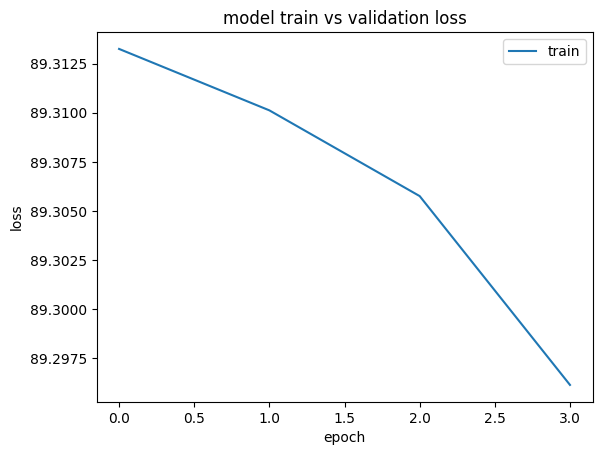

In [43]:
# Plots ##
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [44]:
# Prepare the test data
test_data = [agg_x_test_df['stock_id'].values, agg_x_test_df['date_id'].values, [np.stack(agg_x_test_df[col].values) for col in cols]]

# Make a prediction
predictions = model.predict(test_data)
predictions

194/194 [==============================] - 395s 2s/step


array([[-0.4026844 ,  0.09199392, -0.16293284, ..., -0.28289023,
        -0.1300514 , -0.29100496],
       [-0.24358678,  0.05331263,  0.00654608, ..., -0.07833209,
        -0.10020436, -0.05558769],
       [-0.29797095, -0.08703416,  0.08696886, ..., -0.01605971,
         0.01891152, -0.1938802 ],
       ...,
       [-0.22020948, -0.00129334, -0.12632623, ..., -0.02086699,
         0.01038265, -0.16195014],
       [-0.16840585, -0.14058357, -0.11862832, ...,  0.14744052,
         0.16037853,  0.08457601],
       [-0.11131973, -0.08657559,  0.04680612, ...,  0.18740763,
         0.11207302,  0.10110933]], dtype=float32)

In [46]:
predictions.shape

(6200, 55)

In [35]:
from tensorflow.keras.utils import plot_model

# ... (your existing code)

# Plot the model
plot_model(model, to_file='model_plot_lstm.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [108]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, RepeatVector, UpSampling1D, Attention,Embedding, GRU, SimpleRNN, LayerNormalization, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Bidirectional, TimeDistributed, GlobalAveragePooling1D

build_features(df_train)

#5.8
def build_model(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(25, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

#5.7751
def build_model_2(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(GRU(25, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

#5.9677
def build_model_3(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(25, return_sequences=True)))
    model.add(Dropout(dropout))

    #model.add(Flatten())
    #model.add(UpSampling1D(size=3))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(N_STOCKS))

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

#5.8625
def build_model_4(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Bidirectional(GRU(50, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(SimpleRNN(25, return_sequences=True)))
    model.add(LayerNormalization())
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

#5.8614
def build_model_5(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(GRU(35, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(20, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

#5.9039
def build_model_6(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(GRU(35, return_sequences=True))
    model.add(Dropout(0.65))
    model.add(GRU(20, return_sequences=False))
    model.add(Dropout(0.65))
    model.add(Dense(N_STOCKS))

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model


#5.8969
def build_model_7(dropout=0.65):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Bidirectional(GRU(50, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(25, return_sequences=True)))
    model.add(LayerNormalization())
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256)))
    model.add(Dropout(dropout))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

#6.019
def build_model_8(dropout=0.65):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Bidirectional(GRU(50, return_sequences=True)))
    #model.add(TimeDistributed(GRU(50, return_sequences=True)))
    model.add(Conv1D(filters=64, kernel_size=3))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(dropout))
    model.add(Conv1D(filters=64, kernel_size=3))
    model.add(LayerNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))

    #model.add(Flatten())
    #model.add(Attention())
    #model.add(Reshape((1, 55, 64)))
    #model.add(UpSampling1D(55))
    model.add(RepeatVector(3))
    model.add(Bidirectional(GRU(50, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(25, return_sequences=True)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(64, return_sequences=True))
    model.add(TimeDistributed(Dense(256, activation='tanh')))
    model.add(Dropout(dropout))
    model.add(GRU(50))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))              

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

#5.8793
def build_model_9(dropout=0.3):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Bidirectional(GRU(50, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(25, return_sequences=True)))
    model.add(LayerNormalization())
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256)))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256, activation='tanh')))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(N_STOCKS))              

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

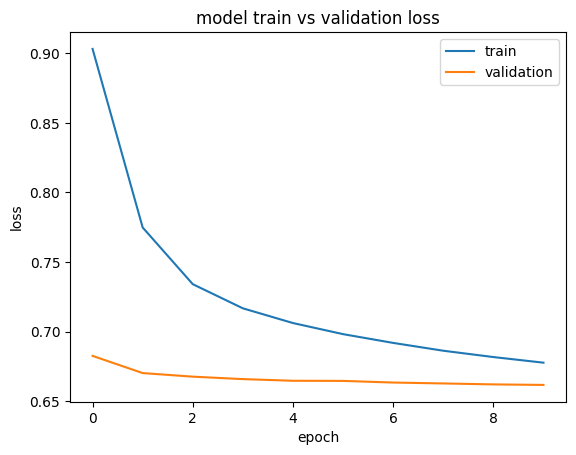